In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
if os.getenv("OPENAI_API_KEY"):
    print("Cargado correctamente API")

Cargado correctamente API


In [2]:
from langchain_openai import ChatOpenAI

MODEL = "gpt-4o-mini"
llm = ChatOpenAI(model=MODEL,temperature=0.4)

In [114]:
#tools
# tool fecha actual
from datetime import datetime, date

def current_date_time():
    """
    Tool: cuando el usuario hable de tiempo usa esta herramienta para determinar la fecha actual,
    realiza las operaciones necesarias para cumplir con la fecha que pide el usuario
    """
    today = date.today().isoformat()
    current_time = datetime.now().isoformat()
    # "current_date":today, 
    return {"current_time": f"Esta es la fecha actual: {current_time} esta en formato ISO" }

In [119]:
tools = [current_date_time]
llm = llm.bind_tools(tools, parallel_tool_calls=False)

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MyState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    intencion: str
    summary: str

In [120]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def identificar_intencion(state: MyState) -> dict:
    system_promp = """Tu tarea es identificar y clasificar la intención del usuario a partir de la conversación proporcionada, usando la siguiente lista de posibles intenciones:

    agendar_cita: El usuario desea reservar o programar una nueva cita.
    consultar_cita: El usuario quiere obtener información sobre una cita ya existente, como la hora o el lugar.
    reagendar_cita: El usuario busca cambiar la fecha o la hora de una cita previamente programada.
    otra: cuando el usuario realiza una conversacion fuera del contexto

    Debes responder solamente con una intención de esta lista: [agendar_cita, consultar_cita, reagendar_cita, otra]
    No agregues mas palabras
    """
    resp = llm.invoke([SystemMessage(content=system_promp)] + state["messages"])
    intencion = resp.content.strip().lower()
    # print(resp)
    return {"messages": state.get("messages","") + [f"intencion identificada: {intencion}"], "intencion": intencion, "summary": state.get("summary","") + f"Intención detectada: {intencion}"}

In [121]:
def consultar_cita(state: MyState) -> dict:
    system_prompt = """Eres una base de datos que tienes agendado citas, cuado el usuario te pida una consulta de cita tu vas a responder con la fecha y la hora de forma simulada.    
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    cita = resp.content
    return {"messages": state["messages"] + [f"{cita}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {cita}"
            }

In [122]:
def agendar_cita(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil que agendas citas, cuando el uasuario te pase la fecha y la hora vas a responder como que ya estubiera agendad la cita.     
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    return {"messages": state["messages"] + [f"{agenda}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {agenda}"
    }

In [123]:
def otra(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil, sigue la conversacion del usuario de forma natural   
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    return {"messages": state["messages"] + [f"{agenda}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {agenda}"
    }

In [124]:
#funcion determinar ruta
def determinar_ruta(state: MyState) -> str:
    intencion = state['intencion']
    if intencion == "consultar_cita":
        return "consultar_cita"
    elif intencion == "agendar_cita":
        return "agendar_cita"
    else: 
        intencion == "otra"
        return "otra"


In [125]:
import sqlite3

db_path="state_db/exmple.db"
conn=sqlite3.connect(db_path,check_same_thread = False)

In [126]:
#checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

In [128]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

#Define Grafo
builder = StateGraph(MyState)

#Define nodos
builder.add_node('identificar_intencion',identificar_intencion)
builder.add_node('consultar_cita',consultar_cita)
builder.add_node('agendar_cita',agendar_cita)
builder.add_node('otra',otra)
builder.add_node("tools", ToolNode(tools))

#Define la secuencia de los agentes para este caso 
builder.add_edge(START,'identificar_intencion')
builder.add_conditional_edges("identificar_intencion",determinar_ruta, {
        "consultar_cita": "consultar_cita",
        "agendar_cita": "agendar_cita",
        "otra": 'otra'
    })
builder.add_edge('consultar_cita',END)
builder.add_edge('agendar_cita',END)
builder.add_edge('otra',END)

#Tambien para definir la secuencia se debe utilizar:
# graph.add_conditional_edges()

#compilar
graph = builder.compile(checkpointer=memory)

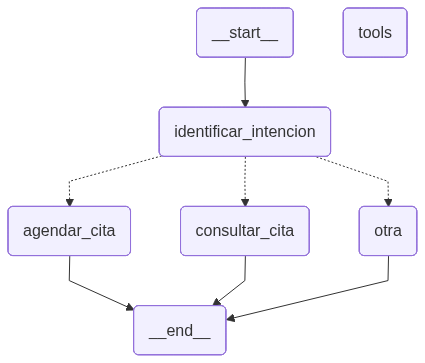

In [129]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [100]:
config = {"configurable": {"thread_id":"2"}}

In [106]:
content = "que nomas puedes hacer"
messages = [HumanMessage(content=content)]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hola cuando tengo la cita con el doctor
================================ Human Message =================================

intencion identificada: consultar_cita
================================ Human Message =================================

Tienes una cita con el doctor el 15 de noviembre de 2023 a las 10:30 AM.
================================ Human Message =================================

puedo agendar una cita
================================ Human Message =================================

intencion identificada: agendar_cita
================================ Human Message =================================

Claro, ¿qué fecha y hora te gustaría agendar para tu cita?
================================ Human Message =================================

recuerdame para cuando tenia gendado la cita con el doctor
================================ Human Message =================================

intencion iden

In [104]:
config = {"configurable": {"thread_id": "2"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='Hola cuando tengo la cita con el doctor', additional_kwargs={}, response_metadata={}, id='0a44c2ef-a871-40fb-ab31-61cc6bb2eb0d'), HumanMessage(content='intencion identificada: consultar_cita', additional_kwargs={}, response_metadata={}, id='fd28620e-7e07-4c5c-91cd-c14887586c54'), HumanMessage(content='Tienes una cita con el doctor el 15 de noviembre de 2023 a las 10:30 AM.', additional_kwargs={}, response_metadata={}, id='c23cd46e-3e24-472f-b124-8f353bad0d33'), HumanMessage(content='puedo agendar una cita', additional_kwargs={}, response_metadata={}, id='ce6b6080-0985-47f5-b546-82a79b4ceedf'), HumanMessage(content='intencion identificada: agendar_cita', additional_kwargs={}, response_metadata={}, id='16855846-cb36-46a0-9f5f-73ae3dbd8e4c'), HumanMessage(content='Claro, ¿qué fecha y hora te gustaría agendar para tu cita?', additional_kwargs={}, response_metadata={}, id='b4bc13e4-2996-4c63-85df-6ad638c47c25')], 'intencion': 'agendar

In [33]:
if __name__ == "__main__":

    state = {
        "messages": [HumanMessage(content="consultar_cita")],
        "summary": ""
    }
    
    result = consultar_cita(state)
    print(result)




None


In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph()